### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #06

#### Name:

In [8]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [9]:
fname= 'eyes_closed_VPal.npz'
cnt, fs, clab, mnt = bci.load_data(fname)

## Exercise 1: Artifact Correction with PCA  (4 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 of the last sheet (\#05) and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

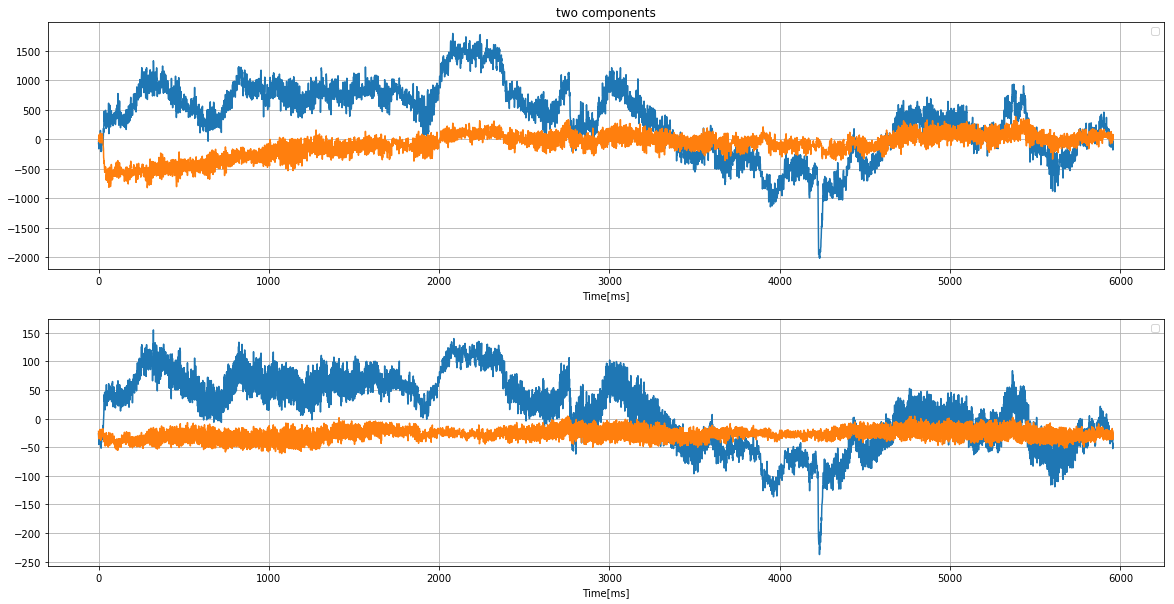

In [59]:
cov = np.cov(cnt)
eigva,eigve = np.linalg.eigh(cov)
#Extract the two largest eigenvectors and multiply them with the data
val1 = eigve[:,-1].dot(cnt)
val2 = eigve[:,-2].dot(cnt)

plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.title("two components")
plt.grid()
plt.plot(val1)
plt.plot(val2)
plt.xlabel("Time[ms]")
plt.legend()

source = eigve.T.dot(cnt)
source[0:-2,:] = 0
eyes = eigve.dot(source)
plt.subplot(2, 1, 2)
diff = cnt -  eyes
index = clab.index('Fz')
plt.grid()
plt.plot(cnt[index])
plt.plot(diff[index])
plt.xlabel("Time[ms]")
plt.legend()

## Exercise 2: PCA on band-pass filtered data (4 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix (functions np.cov and pl.imshow) of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components ins the same way as in Ex. \#01 sheet \#05. Compare the results and discuss shortly.

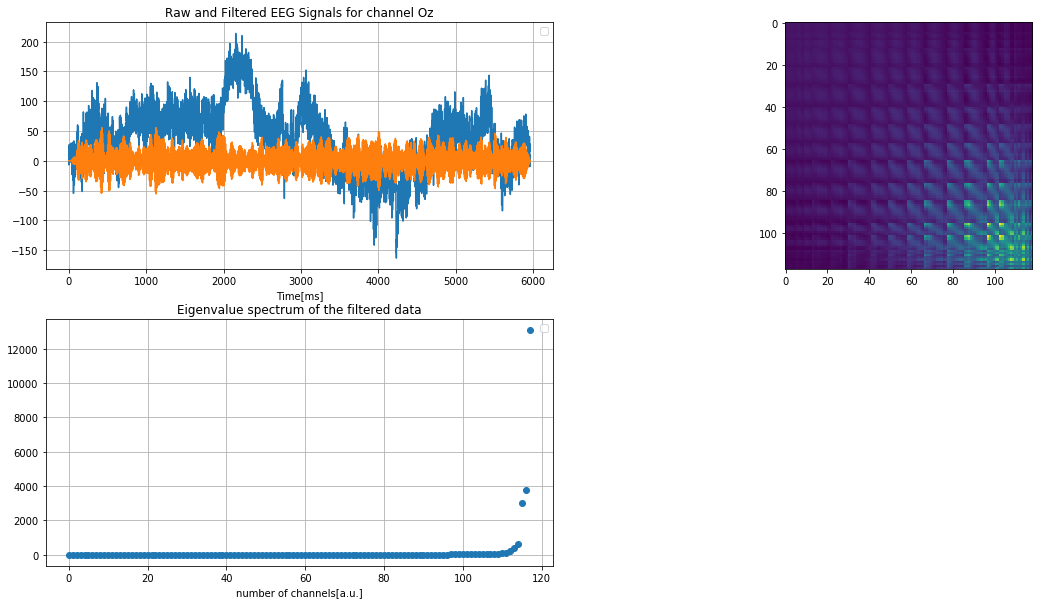

In [61]:
low = 8.0/(0.5*fs)
high = 12.0/(0.5*fs)

b, a = sp.signal.butter(10, [low, high], btype='band')
z = sp.signal.lfilter(b, a, cnt)

oz = clab.index('Oz')
plt.figure(figsize = (20, 10))
plt.subplot(2,2,1)
plt.title("Raw and Filtered EEG Signals for channel Oz")
plt.grid()
plt.plot(cnt[oz])
plt.plot(z[oz])
plt.xlabel("Time[ms]")
plt.legend()

z_cov = np.cov(z)
plt.subplot(2,2,2)
plt.imshow(z_cov)

eva, eve = np.linalg.eigh(z_cov)

plt.subplot(2,2, 3)
plt.title("Eigenvalue spectrum of the filtered data")
plt.plot(eva, 'o')
plt.grid()
plt.xlabel("number of channels[a.u.]")
plt.legend()

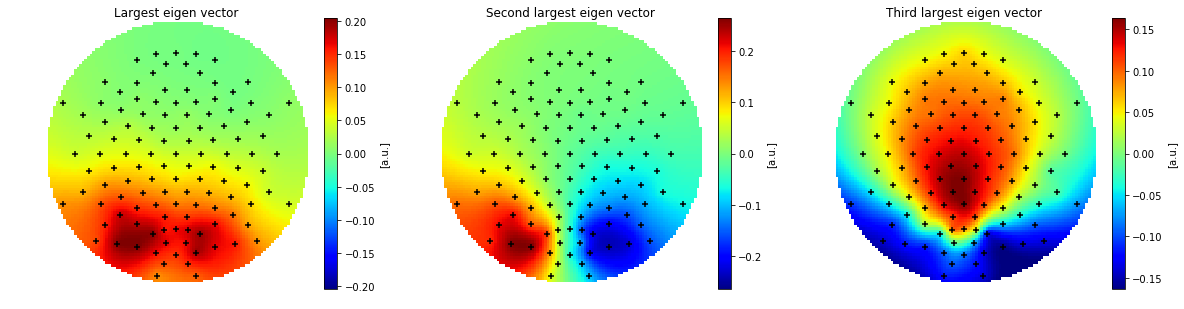

In [56]:
plt.figure(figsize= (20, 10))
plt.subplot(1, 3, 1)
plt.title("Largest eigen vector")
bci.scalpmap(mnt, eve[:,-1], clim='sym', cb_label='[a.u.]')

plt.subplot(1, 3, 2)
plt.title("Second largest eigen vector")
bci.scalpmap(mnt, eve[:,-2], clim='sym', cb_label='[a.u.]')

plt.subplot(1, 3, 3)
plt.title("Third largest eigen vector")
bci.scalpmap(mnt, eve[:,-3], clim='sym', cb_label='[a.u.]')

## Exercise 3: Reconstruction with few PCs  (3 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#02) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure of your choice.

('Error : ', 2.847603012952586)


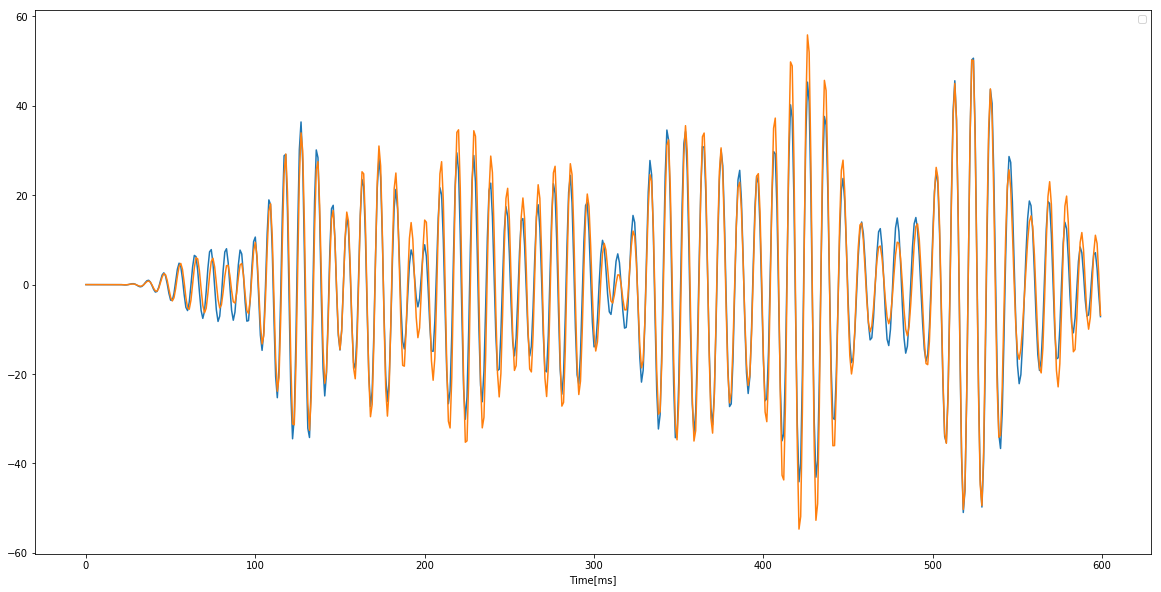

In [71]:
W_arti = eve[:, [-1 ,-2, -3]]
S_arti = W_arti.T.dot(z)
X_arti = W_arti.dot(S_arti)

tm = 600

plt.figure(figsize=(20,10))
plt.plot(X_arti[oz, :tm])
plt.plot(z[oz, :tm])
plt.xlabel("Time[ms]")
plt.legend()

error = np.abs(z - X_arti)
print("Error : ", np.mean(error))

## Exercise 4: Artifact to signal ratio in bandpass-filtered signal  (4 points)
For this task we again assume that the two components from Ex. \#01 sheet \#05 reflect eye movements, while all other components do not contain artifacts from eye movement.

Determine for each channel which proportion of the overall variance caused by these eye movements is left after bandpass-filtering and plot this information as a scalp map. Also, calculate the Signal-To-Noise ratio (SNR) per channel in Decibel (dB).

*Hint: The PCA for these components was done on the unfiltered signal, while the filtered signal has a different covariance matrix.*

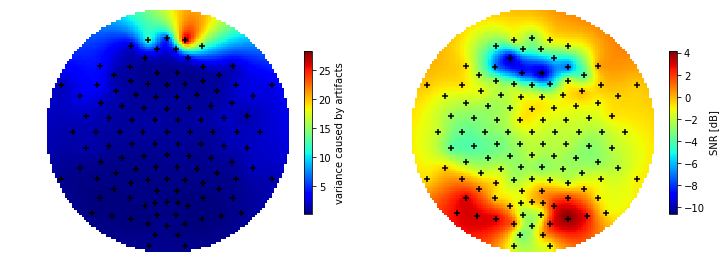

In [93]:
C = np.cov (cnt)
d, V = np.linalg.eigh(C)

W_arti = V[:, [-1 ,-2]]
S_arti = W_arti.T.dot(cnt)
X_arti = W_arti.dot(S_arti)
X_arti_filter = sp.signal.lfilter(b, a, X_arti)

W_rest= V[:,0:-2]
S_rest = W_rest.T.dot(cnt)
X_rest = W_rest.dot(S_rest)
X_rest_filter = sp.signal.lfilter(b, a, X_rest)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
ratio = np.var(X_arti_filter,axis=1) / np.var(z,axis=1)
bci.scalpmap(mnt, ratio, cb_label='variance caused by artifacts')

plt.subplot(1,2,2)
ratio = 10 * np.log10((np.var(X_rest_filter,axis=1))/np.var(X_arti_filter,axis=1))
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')